# Plotting the sources of different bacteria

In [1]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from io import StringIO
from skbio import TreeNode
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [2]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [3]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [4]:
#get labels for publication
pat_id_dict = md_pat.set_index('patient').to_dict()['label_pub']
pat_id_plt_dict = {f'patient_{k}': v for k, v in pat_id_dict.items()}

In [5]:
#read in 16S data
otu = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
otu_rare = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f_rare8500.tsv',
                       sep='\t', index_col=0).astype(int)
otu_ra = otu.div(otu.sum())
#read in taxa
taxa = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/taxonomy.tsv',
                   sep='\t')
taxa[['domain', 'phylum', 'class',
      'order', 'family', 'genus',
      'species']] = taxa['Taxon'].str.split(';', expand=True)

#read in meatgenomics
mtphl = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/metaphlan/deepdive_metaphlan_tax_abun.tsv.gz',
                    sep='\t', index_col=0)
#add taxa level
mtphl.loc[:, 'taxa_level'] = mtphl.index.str.count('\|') + 1

In [6]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

In [7]:
otu_tidy = pd.melt(otu.reset_index(), id_vars='#OTU ID', var_name='sample_id', value_name='count')
otu_tidy = relative_abundance_tidy(otu_tidy, 'sample_id', 'count')
otu_tidy = otu_tidy.merge(md)
otu_tidy = otu_tidy.merge(taxa, left_on='#OTU ID', right_on='Feature ID')

In [8]:
#make a dictionary of colors for bacterial sources
dd_otu_set = {'shared_otus': (0.878, 0.878, 0.878),
              'patient_otus': (0.909, 0.470, 0.470),
              'env_otus': (0.933, 0.674, 0.349),
              'donor0044_otus': (0.305, 0.749, 0.776),
              'donor0073_otus': (0.643, 0.450, 0.850),
              'donor0044_0073_otus': (0.376, 0.470, 0.803),
              'donor_any_otus': (0.376, 0.470, 0.803)}

dd_otu_set_tint = {k: tuple([x + ((255 - 255*x) * 0.8)/255 for x in v]) for k, v in dd_otu_set.items()}

In [9]:
#list donor samples
sam_0044 = md.loc[md['patient'] == '0044']['sample_id'].tolist()
sam_0073 = md.loc[md['patient'] == '0073']['sample_id'].tolist()

#get donor otus
otu_0044 = set(otu[sam_0044].loc[otu[sam_0044].astype(bool).any(axis=1)].index)
otu_0073 = set(otu[sam_0073].loc[otu[sam_0073].astype(bool).any(axis=1)].index)

donor_otus_dict = {'0044': otu_0044, '0073': otu_0073}

In [10]:
#make a tidy dataframe
otu_df = otu_ra.reset_index().melt(id_vars='#OTU ID', 
                                   var_name='sample_id', 
                                   value_name='rel_abundance')
otu_df_md = otu_df.merge(md)
#remove zeroes
otu_df_md = otu_df_md.loc[otu_df_md['rel_abundance'] > 0]

In [11]:
#source track bacteria for each patient
csource_abun = [] #have this be in format [[sample, recipient, donor0044, donor0073, shared, environment]]
csource_ct = [] #also track the otus counts

for patient, pat_df in otu_df_md.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline otus
    bl_sam = md.loc[(md['patient'] == patient) & (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_otus = set(pat_df.loc[pat_df['sample_id'].isin(bl_sam)]['#OTU ID'])
    
    #get patient abx otus
    abx_sam = md.loc[(md['patient'] == patient) & \
                     (md['days_past_fmt'] > -5) & \
                     (md['days_past_fmt'] < 1)]['sample_id'].tolist()
    abx_otus = set(pat_df.loc[pat_df['sample_id'].isin(abx_sam)]['#OTU ID'])
    
    #subtract the abx otus from the donor otus, since they came from before FMT
    otu_0044_noabx = otu_0044 - abx_otus
    otu_0073_noabx = otu_0073 - abx_otus
    
    #source track bacteria for each sample
    for sample, sam_df in pat_df.groupby('sample_id'):
        otus = set(sam_df['#OTU ID'])
        
        # for placebo patients
        if sam_df['treatment'].iloc[0] == 'placebo':
            shared = set()
            src_0044 = set()
            src_0073 = set()
            src_0044_0073 = set()
            src_pat = otus & bl_otus
            env = otus - bl_otus
        
        # in cases of only 0044
        elif set(pat_df['fmt_past']) == set([np.nan, '0044']):
            shared = (otus & otu_0044_noabx & bl_otus)
            src_0044 = (otus & otu_0044_noabx) - bl_otus - abx_otus
            src_0073 = set()
            src_0044_0073 = set()
            src_pat = (otus & bl_otus) - shared
            env = otus - bl_otus - otu_0044_noabx
            
        # in cases of only 0073
        elif set(pat_df['fmt_past']) == set([np.nan, '0073']):
            shared = (otus & otu_0073_noabx & bl_otus)
            src_0044 = set()
            src_0073 = (otus & otu_0073_noabx) - bl_otus
            src_0044_0073 = set()
            src_pat = (otus & bl_otus) - shared
            env = otus - bl_otus - otu_0073_noabx
        
        #in cases of two donors
        elif (set(pat_df['fmt_past']) == set(['0044', '0044, 0073', np.nan])) | \
             (set(pat_df['fmt_past']) == set(['0073', '0044, 0073', np.nan])):
            shared = (otus & otu_0044_noabx & bl_otus) | (otus & otu_0073_noabx & bl_otus)
            src_0044 = (otus & otu_0044_noabx) - bl_otus - otu_0073_noabx
            src_0073 = (otus & otu_0073_noabx) - bl_otus - otu_0044_noabx
            src_0044_0073 = (otus & otu_0044_noabx & otu_0073_noabx) - bl_otus
            src_pat = (otus & bl_otus) - shared
            env = otus - bl_otus - otu_0044_noabx - otu_0073_noabx
        
        otu_sets = [shared, src_0044, src_0073, src_0044_0073, src_pat, env]
        abun = [sam_df.loc[sam_df['#OTU ID'].isin(x)]['rel_abundance'].sum() \
                    for x in otu_sets]
        cts = [len(x) for x in otu_sets]
        
        
        csource_abun.append([sample] + abun)
        csource_ct.append([sample] + cts)

#make into a dataframe
#CUMULATIVE ABUNDANCE
csource_abun_df = pd.DataFrame(csource_abun,
                               columns=['sample_id', 'shared_otus', 'donor0044_otus',
                                        'donor0073_otus', 'donor0044_0073_otus',
                                        'patient_otus', 'env_otus'])
#COUNTS OF OTUS
csource_ct_df = pd.DataFrame(csource_ct,
                             columns=['sample_id', 'shared_otus', 'donor0044_otus',
                                      'donor0073_otus', 'donor0044_0073_otus',
                                      'patient_otus', 'env_otus'])

In [12]:
#melt these tables into tidy tables
csource_abun_df = csource_abun_df.melt(id_vars='sample_id', 
                                       var_name='otu_src', 
                                       value_name='cum_rel_abun')

csource_ct_df = csource_ct_df.melt(id_vars='sample_id', 
                                   var_name='otu_src', 
                                   value_name='otu_count')
#merge these tables
csource_df = csource_abun_df.merge(csource_ct_df)

#add metadata
csource_df = csource_df.merge(md)

In [13]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

#for otu counts, also add a frequency column
csource_df = relative_abundance_tidy(csource_df, 'sample_id', 'otu_count', rel_abun_name='frac_otus')

In [14]:
#write this to a table
csource_df.to_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/csource_df_2019-05-16.tsv',
                  sep='\t', index=False)

In [30]:
csource_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/csource_df_20190206.tsv',
                         sep='\t', dtype={'patient': 'object',
                                          'fmt': 'object',
                                          'fmt_induction': 'object'})

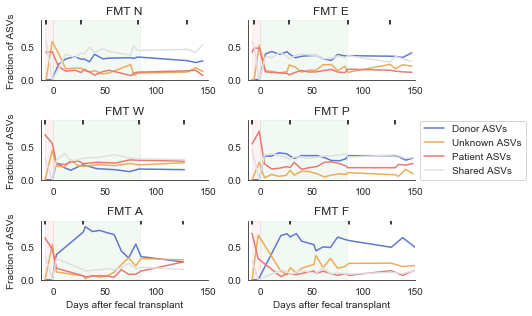

In [17]:
#plot OTU counts abundance for only placebo
#collapse all donor categories
csource_df.loc[:, 'otu_src_bin'] = csource_df['otu_src'].replace({'donor0044_otus': 'donor_any_otus',
                                                                        'donor0073_otus': 'donor_any_otus',
                                                                        'donor0044_0073_otus': 'donor_any_otus'})
#make a new dataframe with these labels
csource_ct_bin_df = csource_df.groupby(['sample_id', 
                                           'otu_src_bin']).sum()
csource_ct_bin_df = csource_ct_bin_df.reset_index()[['sample_id', 
                                                     'otu_src_bin',
                                                     'otu_count',
                                                     'frac_otus']]
csource_ct_bin_df = csource_ct_bin_df.merge(md)

fig = plt.figure(figsize = (7.5,4.5))

counter = 1
for patient, sub_df in csource_ct_bin_df.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='frac_otus',
                 hue='otu_src_bin', data=sub_df, palette=dd_otu_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pat_id_dict[patient])
        
        #set axes
        ax.set_ylim(0, 0.9)
        ax.set_xlim(-12, 150)
        
        #add lines at each of the IBDQ timepoints
        screen_time = min(sub_df['days_past_fmt'].tolist(), 
                          key=lambda x:abs(x - -7))
        week4_time = min(sub_df['days_past_fmt'].tolist(), 
                          key=lambda x:abs(x - 28))
        week12_time = min(sub_df['days_past_fmt'].tolist(), 
                          key=lambda x:abs(x - 84))
        week18_time = min(sub_df['days_past_fmt'].tolist(), 
                          key=lambda x:abs(x - 126))
        
        ax.plot([screen_time, screen_time], 
                [0.85, 1], color='black')
        ax.plot([week4_time, week4_time], 
                [0.85, 1], color='black')
        ax.plot([week12_time, week12_time], 
                [0.85, 1], color='black')
        ax.plot([week18_time, week18_time], 
                [0.85, 1], color='black')
        
        
        if counter in [1, 3, 5]:
            ax.set_ylabel('Fraction of ASVs')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Donor ASVs', 'Unknown ASVs',
                             'Patient ASVs', 'Shared ASVs'])
    
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/soure_plot_16S_otufrac_fmt_simple_2019-05-22.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/soure_plot_16S_otufrac_fmt_simple_2019-05-22.pdf',
            dpi=300)

## MGX Species

In [16]:
#get species
mtphl_sp = mtphl.loc[mtphl['taxa_level'] == 7].reset_index()

#add metadata
mtphl_sp_md = mtphl_sp.merge(md, left_on='sample', right_on='sample_id')

#get donor taxa
taxa_0044 = set(mtphl_sp_md.loc[mtphl_sp_md['patient'] == '0044']['taxa'].unique())
taxa_0073 = set(mtphl_sp_md.loc[mtphl_sp_md['patient'] == '0073']['taxa'].unique())

donor_taxa_dict = {'0044': taxa_0044, '0073': taxa_0073}

In [17]:
#source track bacteria for each patient
csource_abun_mtphl = [] #have this be in format [[sample, recipient, donor0044, donor0073, shared, environment]]
csource_ct_mtphl = [] #also track the otus counts

for patient, pat_df in mtphl_sp_md.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    #get patient baseline otus
    bl_sam = md.loc[(md['patient'] == patient) & (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_taxa = set(pat_df.loc[pat_df['sample_id'].isin(bl_sam)]['taxa'])
    
    #get patient abx otus
    abx_sam = md.loc[(md['patient'] == patient) & \
                     (md['days_past_fmt'] > -5) & \
                     (md['days_past_fmt'] < 1)]['sample_id'].tolist()
    abx_taxa = set(pat_df.loc[pat_df['sample_id'].isin(abx_sam)]['taxa'])
    
    #subtract the abx otus from the donor otus, since they came from before FMT
    taxa_0044_noabx = taxa_0044 - abx_taxa
    taxa_0073_noabx = taxa_0073 - abx_taxa
    
    #source track bacteria for each sample
    for sample, sam_df in pat_df.groupby('sample_id'):
        taxa = set(sam_df['taxa'])
        
        # for placebo patients
        if sam_df['treatment'].iloc[0] == 'placebo':
            shared = set()
            src_0044 = set()
            src_0073 = set()
            src_0044_0073 = set()
            src_pat = taxa & bl_taxa
            env = taxa - bl_taxa
        
        # in cases of only 0044
        elif set(pat_df['fmt_past']) == set([np.nan, '0044']):
            shared = (taxa & taxa_0044_noabx & bl_taxa)
            src_0044 = (taxa & taxa_0044_noabx) - bl_taxa
            src_0073 = set()
            src_0044_0073 = set()
            src_pat = (taxa & bl_taxa) - shared
            env = taxa - bl_taxa - taxa_0044_noabx
            
        # in cases of only 0073
        elif set(pat_df['fmt_past']) == set([np.nan, '0073']):
            shared = (taxa & taxa_0073_noabx & bl_taxa)
            src_0044 = set()
            src_0073 = (taxa & taxa_0073_noabx) - bl_taxa
            src_0044_0073 = set()
            src_pat = (taxa & bl_taxa) - shared
            env = taxa - bl_taxa - taxa_0073_noabx
        
        #in cases of two donors
        elif (set(pat_df['fmt_past']) == set(['0044', '0044, 0073', np.nan])) | \
             (set(pat_df['fmt_past']) == set(['0073', '0044, 0073', np.nan])):
            shared = (taxa & taxa_0044_noabx & bl_taxa) | (taxa & taxa_0073_noabx & bl_taxa)
            src_0044 = (taxa & taxa_0044_noabx) - bl_taxa - taxa_0073_noabx
            src_0073 = (taxa & taxa_0073_noabx) - bl_taxa - taxa_0044_noabx
            src_0044_0073 = (taxa & taxa_0044_noabx & taxa_0073_noabx) - bl_taxa
            src_pat = (taxa & bl_taxa) - shared
            env = taxa - bl_taxa - taxa_0044_noabx - taxa_0073_noabx
        
        taxa_sets = [shared, src_0044, src_0073, src_0044_0073, src_pat, env]
        abun = [sam_df.loc[sam_df['taxa'].isin(x)]['rel_abundance'].sum() \
                    for x in taxa_sets]
        cts = [len(x) for x in taxa_sets]
        
        
        csource_abun_mtphl.append([sample] + abun)
        csource_ct_mtphl.append([sample] + cts)

#make into a dataframe
#CUMULATIVE ABUNDANCE
csource_abun_mtphl_df = pd.DataFrame(csource_abun_mtphl,
                                     columns=['sample_id', 'shared_taxa', 'donor0044_taxa',
                                              'donor0073_taxa', 'donor0044_0073_taxa',
                                              'patient_taxa', 'env_taxa'])
#COUNTS OF OTUS
csource_ct_mtphl_df = pd.DataFrame(csource_ct_mtphl,
                                   columns=['sample_id', 'shared_taxa', 'donor0044_taxa',
                                            'donor0073_taxa', 'donor0044_0073_taxa',
                                            'patient_taxa', 'env_taxa'])

In [18]:
#melt these tables into tidy tables
csource_abun_mtphl_df = csource_abun_mtphl_df.melt(id_vars='sample_id', 
                                       var_name='taxa_src', 
                                       value_name='cum_rel_abun')

csource_ct_mtphl_df = csource_ct_mtphl_df.melt(id_vars='sample_id', 
                                   var_name='taxa_src', 
                                   value_name='taxa_count')
#merge these tables
csource_mtphl_df = csource_abun_mtphl_df.merge(csource_ct_mtphl_df)

#add metadata
csource_mtphl_df = csource_mtphl_df.merge(md)

In [19]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

#for otu counts, also add a frequency column
csource_mtphl_df = relative_abundance_tidy(csource_mtphl_df, 'sample_id', 
                                           'taxa_count', rel_abun_name='frac_mgx_sp')

In [20]:
#write this to a table
csource_mtphl_df.to_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/csource_mtphl_df_2019-05-16.tsv',
                        sep='\t', index=False)

In [ ]:
#read this to a table
csource_mtphl_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/csource_mtphl_df_2019-05-16.tsv',
                               sep='\t', dtype={'patient': 'object',
                                                'fmt': 'object',
                                                'fmt_induction': 'object'})

In [21]:
dd_taxa_set = {f'{k[:-5]}_taxa': v for k, v in dd_otu_set.items()}

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


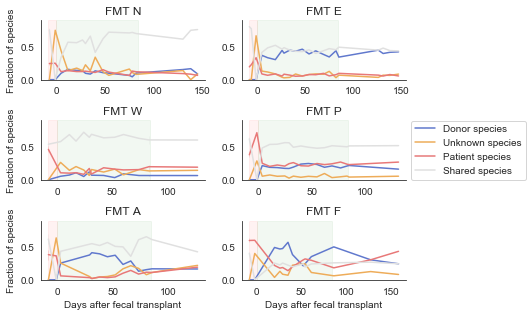

In [22]:
#plot OTU counts abundance for only placebo
#collapse all donor categories
csource_mtphl_df.loc[:, 'taxa_src_bin'] = csource_mtphl_df['taxa_src'].replace({'donor0044_taxa': 'donor_any_taxa',
                                                                              'donor0073_taxa': 'donor_any_taxa',
                                                                              'donor0044_0073_taxa': 'donor_any_taxa'})
#make a new dataframe with these labels
csource_mtphl_bin_df = csource_mtphl_df.groupby(['sample_id', 
                                           'taxa_src_bin']).sum()
csource_mtphl_bin_df = csource_mtphl_bin_df.reset_index()[['sample_id', 
                                                     'taxa_src_bin',
                                                     'taxa_count',
                                                     'frac_mgx_sp']]
csource_mtphl_bin_df = csource_mtphl_bin_df.merge(md)

fig = plt.figure(figsize = (7.5,4.5))

counter = 1
for patient, sub_df in csource_mtphl_bin_df.groupby('patient'):
    if patient in ['001', '007', '008', '010', '011', '014']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='frac_mgx_sp',
                 hue='taxa_src_bin', data=sub_df, palette=dd_taxa_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pat_id_dict[patient])
        
        ax.set_ylim(0, 0.9)
        
        if counter in [1, 3, 5]:
            ax.set_ylabel('Fraction of species')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Donor species', 'Unknown species',
                             'Patient species', 'Shared species'])
    
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/soure_plot_mgx_mgxfrac_fmt_simple_2019-05-16.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/soure_plot_mgx_mgxfrac_fmt_simple_2019-05-16.pdf',
            dpi=300)

## Gut check source plots for placebo patients

In [18]:
#source track bacteria for each placebo patient
#let's first check with only donor 44
plc_dsrc_chk_abun = [] #have this be in format [[sample, recipient, donor0044, donor0073, shared, environment]]
plc_dsrc_chk_ct = [] #also track the otus counts

for patient, pat_df in otu_df_md.groupby('patient'):
    if patient in ['0044', '0073', '001', '007', '008',
                   '010', '011', '014']:
        continue
    #get patient baseline otus
    bl_sam = md.loc[(md['patient'] == patient) & (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_otus = set(pat_df.loc[pat_df['sample_id'].isin(bl_sam)]['#OTU ID'])
    
    #get patient abx otus
    abx_sam = md.loc[(md['patient'] == patient) & \
                     (md['days_past_fmt'] > -5) & \
                     (md['days_past_fmt'] < 1)]['sample_id'].tolist()
    abx_otus = set(pat_df.loc[pat_df['sample_id'].isin(abx_sam)]['#OTU ID'])
    
    #subtract the abx otus from the donor otus, since they came from before FMT
    otu_0044_noabx = otu_0044 - abx_otus
    
    #source track bacteria for each sample
    for sample, sam_df in pat_df.groupby('sample_id'):
        otus = set(sam_df['#OTU ID'])
        
        # for placebo patients with donor 0044
        shared = (otus & otu_0044_noabx & bl_otus)
        src_0044 = (otus & otu_0044_noabx) - bl_otus - abx_otus
        src_0073 = set()
        src_0044_0073 = set()
        src_pat = (otus & bl_otus) - shared
        env = otus - bl_otus - otu_0044_noabx
        
        otu_sets = [shared, src_0044, src_0073, src_0044_0073, src_pat, env]
        abun = [sam_df.loc[sam_df['#OTU ID'].isin(x)]['rel_abundance'].sum() \
                    for x in otu_sets]
        cts = [len(x) for x in otu_sets]
        
        
        plc_dsrc_chk_abun.append([sample] + abun)
        plc_dsrc_chk_ct.append([sample] + cts)

#make into a dataframe
#CUMULATIVE ABUNDANCE
plc_dsrc_chk_abun_df = pd.DataFrame(plc_dsrc_chk_abun,
                               columns=['sample_id', 'shared_otus', 'donor0044_otus',
                                        'donor0073_otus', 'donor0044_0073_otus',
                                        'patient_otus', 'env_otus'])
#COUNTS OF OTUS
plc_dsrc_chk_ct_df = pd.DataFrame(plc_dsrc_chk_ct,
                             columns=['sample_id', 'shared_otus', 'donor0044_otus',
                                      'donor0073_otus', 'donor0044_0073_otus',
                                      'patient_otus', 'env_otus'])

In [19]:
#melt these tables into tidy tables
plc_dsrc_chk_abun_df = plc_dsrc_chk_abun_df.melt(id_vars='sample_id', 
                                       var_name='otu_src', 
                                       value_name='cum_rel_abun')

plc_dsrc_chk_ct_df = plc_dsrc_chk_ct_df.melt(id_vars='sample_id', 
                                   var_name='otu_src', 
                                   value_name='otu_count')
#merge these tables
plc_dsrc_chk_df = plc_dsrc_chk_abun_df.merge(plc_dsrc_chk_ct_df)

#add metadata
plc_dsrc_chk_df = plc_dsrc_chk_df.merge(md)

In [20]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

#for otu counts, also add a frequency column
plc_dsrc_chk_df = relative_abundance_tidy(plc_dsrc_chk_df, 
                                          'sample_id', 'otu_count', 
                                          rel_abun_name='frac_otus')

In [21]:
#write this to a table
plc_dsrc_chk_df.to_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/csource_placebo_check_0044_df_2019-05-22.tsv',
                  sep='\t', index=False)

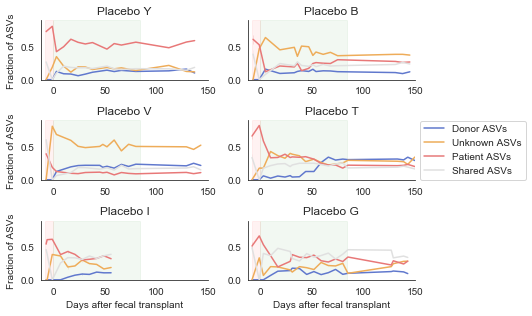

In [24]:
#plot OTU counts abundance for only placebo
#collapse all donor categories
plc_dsrc_chk_df.loc[:, 'otu_src_bin'] = plc_dsrc_chk_df['otu_src'].replace({'donor0044_otus': 'donor_any_otus',
                                                                        'donor0073_otus': 'donor_any_otus',
                                                                        'donor0044_0073_otus': 'donor_any_otus'})
#make a new dataframe with these labels
plc_dsrc_chk_bin_df = plc_dsrc_chk_df.groupby(['sample_id', 
                                           'otu_src_bin']).sum()
plc_dsrc_chk_bin_df = plc_dsrc_chk_bin_df.reset_index()[['sample_id', 
                                                     'otu_src_bin',
                                                     'otu_count',
                                                     'frac_otus']]
plc_dsrc_chk_bin_df = plc_dsrc_chk_bin_df.merge(md)

fig = plt.figure(figsize = (7.5,4.5))

counter = 1
for patient, sub_df in plc_dsrc_chk_bin_df.groupby('patient'):
    if patient in ['004', '005', '006', '009', '012', '013']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='frac_otus',
                 hue='otu_src_bin', data=sub_df, palette=dd_otu_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pat_id_dict[patient])
        
        #set axes
        ax.set_ylim(0, 0.9)
        ax.set_xlim(-12, 150)
        
        if counter in [1, 3, 5]:
            ax.set_ylabel('Fraction of ASVs')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Donor ASVs', 'Unknown ASVs',
                             'Patient ASVs', 'Shared ASVs'])
    
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/source_placebo_chk44_16S_otufrac_2019-05-22.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/source_placebo_chk44_16S_otufrac_2019-05-22.pdf',
            dpi=300)

In [25]:
#source track bacteria for each placebo patient
#let's first check with only donor 44
plc_dsrc_chk_abun = [] #have this be in format [[sample, recipient, donor0044, donor0073, shared, environment]]
plc_dsrc_chk_ct = [] #also track the otus counts

for patient, pat_df in otu_df_md.groupby('patient'):
    if patient in ['0044', '0073', '001', '007', '008',
                   '010', '011', '014']:
        continue
    #get patient baseline otus
    bl_sam = md.loc[(md['patient'] == patient) & (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_otus = set(pat_df.loc[pat_df['sample_id'].isin(bl_sam)]['#OTU ID'])
    
    #get patient abx otus
    abx_sam = md.loc[(md['patient'] == patient) & \
                     (md['days_past_fmt'] > -5) & \
                     (md['days_past_fmt'] < 1)]['sample_id'].tolist()
    abx_otus = set(pat_df.loc[pat_df['sample_id'].isin(abx_sam)]['#OTU ID'])
    
    #subtract the abx otus from the donor otus, since they came from before FMT
    otu_0073_noabx = otu_0073 - abx_otus
    
    #source track bacteria for each sample
    for sample, sam_df in pat_df.groupby('sample_id'):
        otus = set(sam_df['#OTU ID'])
        
        # for placebo patients with donor 0044
        shared = (otus & otu_0073_noabx & bl_otus)
        src_0044 = set()
        src_0073 = (otus & otu_0073_noabx) - bl_otus
        src_0044_0073 = set()
        src_pat = (otus & bl_otus) - shared
        env = otus - bl_otus - otu_0073_noabx
        
        otu_sets = [shared, src_0044, src_0073, src_0044_0073, src_pat, env]
        abun = [sam_df.loc[sam_df['#OTU ID'].isin(x)]['rel_abundance'].sum() \
                    for x in otu_sets]
        cts = [len(x) for x in otu_sets]
        
        
        plc_dsrc_chk_abun.append([sample] + abun)
        plc_dsrc_chk_ct.append([sample] + cts)

#make into a dataframe
#CUMULATIVE ABUNDANCE
plc_dsrc_chk_abun_df = pd.DataFrame(plc_dsrc_chk_abun,
                               columns=['sample_id', 'shared_otus', 'donor0044_otus',
                                        'donor0073_otus', 'donor0044_0073_otus',
                                        'patient_otus', 'env_otus'])
#COUNTS OF OTUS
plc_dsrc_chk_ct_df = pd.DataFrame(plc_dsrc_chk_ct,
                             columns=['sample_id', 'shared_otus', 'donor0044_otus',
                                      'donor0073_otus', 'donor0044_0073_otus',
                                      'patient_otus', 'env_otus'])

In [26]:
#melt these tables into tidy tables
plc_dsrc_chk_abun_df = plc_dsrc_chk_abun_df.melt(id_vars='sample_id', 
                                       var_name='otu_src', 
                                       value_name='cum_rel_abun')

plc_dsrc_chk_ct_df = plc_dsrc_chk_ct_df.melt(id_vars='sample_id', 
                                   var_name='otu_src', 
                                   value_name='otu_count')
#merge these tables
plc_dsrc_chk_df = plc_dsrc_chk_abun_df.merge(plc_dsrc_chk_ct_df)

#add metadata
plc_dsrc_chk_df = plc_dsrc_chk_df.merge(md)

In [27]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

#for otu counts, also add a frequency column
plc_dsrc_chk_df = relative_abundance_tidy(plc_dsrc_chk_df, 
                                          'sample_id', 'otu_count', 
                                          rel_abun_name='frac_otus')

In [28]:
#write this to a table
plc_dsrc_chk_df.to_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/csource_placebo_check_0073_df_2019-05-22.tsv',
                  sep='\t', index=False)

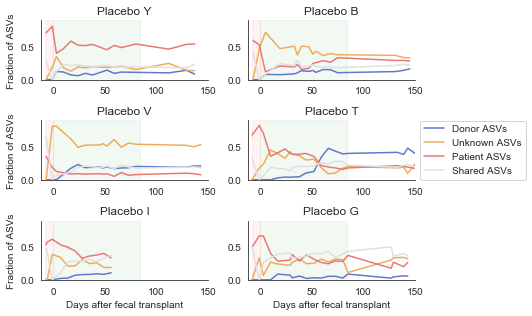

In [29]:
#plot OTU counts abundance for only placebo
#collapse all donor categories
plc_dsrc_chk_df.loc[:, 'otu_src_bin'] = plc_dsrc_chk_df['otu_src'].replace({'donor0044_otus': 'donor_any_otus',
                                                                        'donor0073_otus': 'donor_any_otus',
                                                                        'donor0044_0073_otus': 'donor_any_otus'})
#make a new dataframe with these labels
plc_dsrc_chk_bin_df = plc_dsrc_chk_df.groupby(['sample_id', 
                                           'otu_src_bin']).sum()
plc_dsrc_chk_bin_df = plc_dsrc_chk_bin_df.reset_index()[['sample_id', 
                                                     'otu_src_bin',
                                                     'otu_count',
                                                     'frac_otus']]
plc_dsrc_chk_bin_df = plc_dsrc_chk_bin_df.merge(md)

fig = plt.figure(figsize = (7.5,4.5))

counter = 1
for patient, sub_df in plc_dsrc_chk_bin_df.groupby('patient'):
    if patient in ['004', '005', '006', '009', '012', '013']:
        ax = fig.add_subplot(3,2,counter)
        sns.lineplot(x='days_past_fmt', y='frac_otus',
                 hue='otu_src_bin', data=sub_df, palette=dd_otu_set)
        
        ax.axvspan(-8, 0, alpha=0.05, color='red') #antibiotics
        ax.axvspan(0, 84, alpha=0.05, color='green') #capsules
        
        ax.set_title(pat_id_dict[patient])
        
        #set axes
        ax.set_ylim(0, 0.9)
        ax.set_xlim(-12, 150)
        
        if counter in [1, 3, 5]:
            ax.set_ylabel('Fraction of ASVs')
        else:
            ax.set_ylabel('')
        
        if counter in [5, 6]:
            ax.set_xlabel('Days after fecal transplant')
        else:
            ax.set_xlabel('')
        
        if counter != 4:
            ax.legend_.remove()
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                     labels=['Donor ASVs', 'Unknown ASVs',
                             'Patient ASVs', 'Shared ASVs'])
    
        counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/source_placebo_chk73_16S_otufrac_2019-05-22.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/source_placebo_chk73_16S_otufrac_2019-05-22.pdf',
            dpi=300)

## Counts of shared, distinct, and transferred 

In [31]:
csource_df.head()

,sample_id,otu_src,cum_rel_abun,otu_count,storage,barcode_id,patient_donor,patient,approx_wk,days_past_fmt,...,fmt_current,fmt_past,clinical_intervention,responder_fmt,reads_16s,reads_mgx,sample_mimarks,notes,patient_plt,frac_otus
0,03-133,shared_otus,0.848979,30,rna_later,BP-17.0622,patient,001,12.0,82.0,...,44.0,"0044, 0073",True,nonresponder,200032.0,17985300.0,03.133,NaN,patient_001,0.491803
1,03-133,donor0044_otus,0.050746,8,rna_later,BP-17.0622,patient,001,12.0,82.0,...,44.0,"0044, 0073",True,nonresponder,200032.0,17985300.0,03.133,NaN,patient_001,0.131148
2,03-133,donor0073_otus,0.005543,4,rna_later,BP-17.0622,patient,001,12.0,82.0,...,44.0,"0044, 0073",True,nonresponder,200032.0,17985300.0,03.133,NaN,patient_001,0.065574
3,03-133,donor0044_0073_otus,0.073640,9,rna_later,BP-17.0622,patient,001,12.0,82.0,...,44.0,"0044, 0073",True,nonresponder,200032.0,17985300.0,03.133,NaN,patient_001,0.147541
4,03-133,patient_otus,0.009509,4,rna_later,BP-17.0622,patient,001,12.0,82.0,...,44.0,"0044, 0073",True,nonresponder,200032.0,17985300.0,03.133,NaN,patient_001,0.065574
